<a href="https://colab.research.google.com/github/rpitonak/building-segmentation/blob/master/building_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Open Cities AI Challenge: Segmenting Buildings for Disaster Resilience

This is my solution to [Open Cities AI Challenge: Segmenting Buildings for Disaster Resilience](https://www.drivendata.org/competitions/60/building-segmentation-disaster-resilience/page/150/).

Sources:

1) How to prepare [patches of data for training](https://medium.com/@anthropoco/how-to-segment-buildings-on-drone-imagery-with-fast-ai-cloud-native-geodata-tools-ae249612c321).


2) [Getting started guide](https://colab.research.google.com/drive/1Fv-80b1m-O-0p1g59NDzD82XdgurWlwa) from [johnowhitaker](https://community.drivendata.org/u/johnowhitaker/summary).

3) [Fast.AI](https://docs.fast.ai/)

Google colab notebook was bootstraped using [colab-bootstrap](https://github.com/zaitra/colab-bootstrap) by [Zaitra](https://zaitra.io).


# Install python packages

In [0]:
!pip3 install geopandas pillow rasterio descartes rio-tiler pystac

# Imports

In [0]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import sys
import os
import datetime
from enum import Enum
from pathlib import Path


#import solaris as sol
# Basics of Python data handling and visualization
import skimage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.transform import from_bounds
from rasterio.windows import Window
from rio_tiler import main as rt_main

from shapely.geometry import Polygon
from shapely.ops import cascaded_union

from pystac import Catalog, CatalogType, Item, Asset, LabelItem, Collection
from tqdm import tqdm

# Google drive

Mount google drive folder with data to machine provided by google collab.

In [4]:
import os

from google.colab import drive
from pathlib import Path

drive.mount('/content/gdrive')

GOOGLE_DRIVE_PATH = Path('/content/gdrive/My Drive')
WORKDIR = 'segmentation' # specify the path to folder which you are intend to work with in this notebook
WORKDIR_PATH = GOOGLE_DRIVE_PATH / WORKDIR

if not os.path.exists(WORKDIR_PATH):
          os.mkdir(WORKDIR_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Set the paths

In [0]:
IMG_PATH = WORKDIR_PATH /'images-256'
MASK_PATH = WORKDIR_PATH /'masks-256'
IMG_PATH.mkdir(exist_ok=True)
MASK_PATH.mkdir(exist_ok=True)

Load metadata as dataframe

In [7]:
import glob

# List of images
img_glob = glob.glob(str(IMG_PATH) + '/*.png')
mask_glob = [im.replace('images', 'masks').replace('.png', '_mask.png') for im in img_glob]
df = pd.DataFrame({
    'img_path': img_glob, #[i.lstrip("/") for i in img_glob],
    'mask_path': mask_glob, #[m.lstrip("/") for m in mask_glob],
    'validation_set': False
})

# Add some useful columns
df['scene_id'] = df['img_path'].apply(lambda x: x.split("_")[1])
df['area'] = df['img_path'].apply(lambda x: x.split("_")[0].split("/")[-1])

# View
df.head()

,img_path,mask_path,validation_set,scene_id,area
0,/content/gdrive/My Drive/segmentation/images-2...,/content/gdrive/My Drive/segmentation/masks-25...,False,bc32f1,znz
1,/content/gdrive/My Drive/segmentation/images-2...,/content/gdrive/My Drive/segmentation/masks-25...,False,bc32f1,znz
2,/content/gdrive/My Drive/segmentation/images-2...,/content/gdrive/My Drive/segmentation/masks-25...,False,bc32f1,znz
3,/content/gdrive/My Drive/segmentation/images-2...,/content/gdrive/My Drive/segmentation/masks-25...,False,bc32f1,znz
4,/content/gdrive/My Drive/segmentation/images-2...,/content/gdrive/My Drive/segmentation/masks-25...,False,bc32f1,znz


Check how many tiles we have in each area

In [8]:
df.groupby('area').count()['scene_id']

area
acc     1619
dar     1974
kam      239
mon      444
nia      160
ptn      400
znz    17113
Name: scene_id, dtype: int64

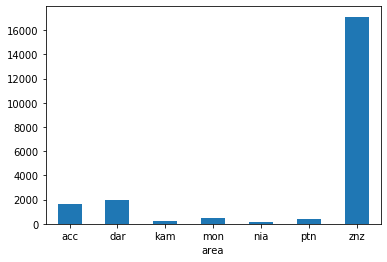

In [9]:
ax = df.groupby('area').count()['scene_id'].plot.bar(x='area', y='val', rot=0)

Create a validation set from **ptn** area.

In [0]:
df.loc[df.area == 'ptn', 'validation_set'] = True

Load dataset using [Data block API](https://docs.fast.ai/data_block.html#The-data-block-API)

In [0]:
from fastai.vision import *
import torch

# Override open method of SegmentationLabelList since our masks are 0 for class 0, 255 for class 1 (so need div=True)
def my_open(self, fn):
   return open_mask(fn, div=True)

SegmentationLabelList.open = my_open

np.random.seed(42)

# Load the data from the dataframe
src = (SegmentationItemList.from_df(path='/', df=df, cols="img_path")
       .split_from_df(col='validation_set')
       .label_from_df(cols='mask_path', classes=["building", "not"]))

data = (src.transform(get_transforms(), size=256, tfm_y=True)
        .databunch(bs=16) # Change batch size if you're having memory issues
        .normalize(imagenet_stats))

Display sample batch

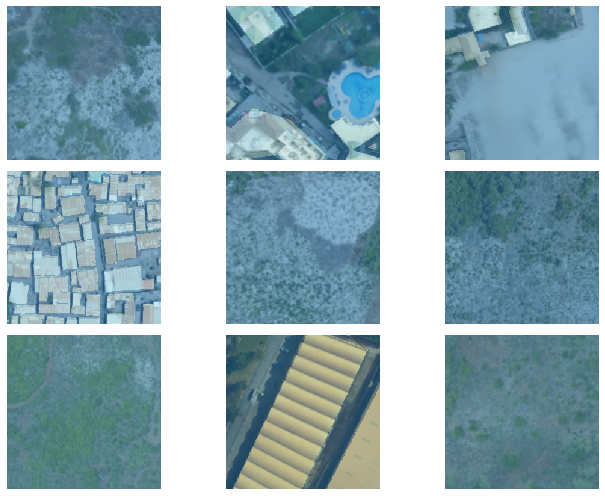

In [15]:
data.show_batch(3, figsize=(10,7))

Create custom loss function

In [0]:
import sklearn.metrics

def jq(y_pred, y_true, thresh=0.50):
    scores = []
    for i in range(len(y_true)):
        binary_preds =  (y_pred[i][0].flatten()>thresh).int()
        score = sklearn.metrics.jaccard_score(y_true[i].flatten().cpu(), binary_preds.cpu(), average='micro')
        scores.append(score)
    return torch.tensor(sum(scores)/len(scores))


Initialize the model. You can try different backbones (e.g Resnet50 or deeper) to get better results. Unfortunetely it will also increase the training time.

In [17]:
learn = unet_learner(data, models.resnet34, metrics=jq)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Pick a learning rate

epoch,train_loss,valid_loss,jq,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


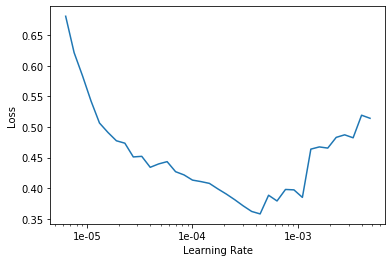

In [0]:
learn.lr_find(start_lr=1e-6, end_lr=1e2)
learn.recorder.plot()

Use learning rate and cycle method of training. Try to increase the number of epochs to obtain better results.

In [18]:
lr = 1e-4
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,jq,time
0,0.078555,0.224129,0.065729,36:14


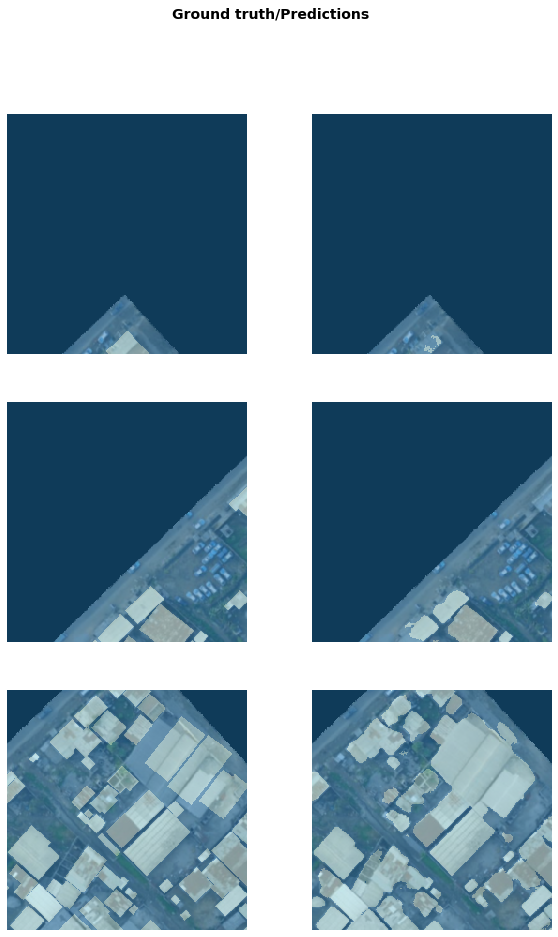

In [0]:
learn.show_results(rows=3, figsize=(10,15))

Train the whole network to for one epoch to get a little bit better accuracy. This is a common strategy when transfer learning is used.

In [19]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,jq,time
0,0.069191,0.203705,0.052548,09:14


Save the resulting model, so we can load it from disk any time later, to continue training or make predictions.

In [0]:
learn.save(WORKDIR_PATH / 'export.pkl')